## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from torchmetrics.functional.classification import *
from skorch import NeuralNetClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, InputSpec
from keras.utils import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from skmultilearn.ext import Keras
from scipy.sparse import lil_matrix

In [2]:
DROPOUT_RATE = 0.2

## Read Data

In [3]:
data = pd.read_csv('D:\Project\project-ednn\Code\Final_dataset_Diabetes_Complication.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,3,1,1,1,1,1,1,1,3,1,...,1,3,1,2,2,1,2,2,1,2
1,5,3,1,1,2,4,2,1,5,1,...,1,2,2,2,2,2,2,2,1,1
2,4,1,1,1,2,1,2,2,2,2,...,2,3,1,2,2,2,2,2,2,1
3,4,1,1,1,2,4,2,1,1,1,...,2,3,2,2,2,2,1,2,1,2
4,2,1,1,3,1,3,1,1,1,1,...,1,3,1,2,2,2,2,2,2,2


In [4]:
data = data.drop_duplicates(ignore_index=True)
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,3,1,1,1,1,1,1,1,3,1,...,1,3,1,2,2,1,2,2,1,2
1,5,3,1,1,2,4,2,1,5,1,...,1,2,2,2,2,2,2,2,1,1
2,4,1,1,1,2,1,2,2,2,2,...,2,3,1,2,2,2,2,2,2,1
3,4,1,1,1,2,4,2,1,1,1,...,2,3,2,2,2,2,1,2,1,2
4,2,1,1,3,1,3,1,1,1,1,...,1,3,1,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543770,1,1,2,1,1,4,1,1,5,2,...,2,3,1,2,2,2,2,2,2,2
543771,2,1,1,1,1,4,1,1,5,1,...,1,2,2,2,2,1,2,2,2,1
543772,1,2,1,1,1,3,1,1,2,1,...,1,3,1,2,2,2,2,2,2,1
543773,3,1,2,1,1,3,1,1,2,2,...,1,3,2,2,2,2,2,1,2,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543775 entries, 0 to 543774
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   X1      543775 non-null  int64
 1   X2      543775 non-null  int64
 2   X3      543775 non-null  int64
 3   X4      543775 non-null  int64
 4   X5      543775 non-null  int64
 5   X6      543775 non-null  int64
 6   X7      543775 non-null  int64
 7   X8      543775 non-null  int64
 8   X9      543775 non-null  int64
 9   X10     543775 non-null  int64
 10  X11     543775 non-null  int64
 11  X12     543775 non-null  int64
 12  X13     543775 non-null  int64
 13  X14     543775 non-null  int64
 14  X15     543775 non-null  int64
 15  X16     543775 non-null  int64
 16  X17     543775 non-null  int64
 17  X18     543775 non-null  int64
 18  X19     543775 non-null  int64
 19  X20     543775 non-null  int64
 20  X21     543775 non-null  int64
 21  X22     543775 non-null  int64
 22  X23     543775 non-n

## Data Visualization

In [6]:
data_feature = data.iloc[:, :26]
data_label = data.iloc[:, 26:]
data_label

,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,2,2,1,2,2,1,2
1,2,2,2,2,2,1,1
2,2,2,2,2,2,2,1
3,2,2,2,1,2,1,2
4,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
543770,2,2,2,2,2,2,2
543771,2,2,1,2,2,2,1
543772,2,2,2,2,2,2,1
543773,2,2,2,2,1,2,2


## Data Preprocessing

In [7]:
scaler = MinMaxScaler()
scaler.fit(data)

# Transform the DataFrame to obtain the normalized data
data_normalized = scaler.transform(data)

In [8]:
X = data_normalized[:, :26]
y = data_normalized[:, 26:]

In [9]:
data_normalize = pd.DataFrame(scaler.transform(data), columns=data.columns)
df_feature = data_normalize.iloc[:, :26]
df_label = data_normalize.iloc[:, 26:]

## Modelling

In [10]:
weight_list = []
for i, label in enumerate(df_label.columns):
    values_1 = df_label[label][df_label[label] == 1]
    values_2 = df_label[label][df_label[label] == 2]
    dist = 1 - (len(values_1) / len(df_label))
    weight_list.append(dist)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
weights_ = torch.Tensor(weight_list).to(device)
weights_

tensor([0.0483, 0.0652, 0.0605, 0.0508, 0.1008, 0.3895, 0.4290],
       device='cuda:0')

In [13]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [14]:
class DNNModelwithWeightedDropout(tf.keras.Model):
    def __init__(self, num_features=26, num_classes=7, p=[0.05, 0.01, 0.003]):
        super(DNNModelwithWeightedDropout, self).__init__()
        self.fcn1 = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)),
            tf.keras.layers.Dense(len(p), activation='softmax')
        ])
        self.dropout = [tf.keras.layers.Dropout(rate=rate) for rate in p]
        self.fcn2 = tf.keras.Sequential([
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

    def call(self, x, training=None, mask=None):
        x = self.fcn1(x)
        weights = x

        # Apply weighted dropout
        x = [dropout(x[:, i], training=training) * weights[:, i] for i, dropout in enumerate(self.dropout)]

        x = tf.stack(x, axis=1)
        x = self.fcn2(x)
        return x

In [42]:
class DNNTrainable(tf.keras.Model):
    def __init__(self, num_features=26, num_classes=7, p=[0.05, 0.01, 0.003]):
        super(DNNTrainable, self).__init__()

        self.fcn1 = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        self.dropout1 = tf.keras.layers.Dropout(p[0])
        self.dropout2 = tf.keras.layers.Dropout(p[1])
        self.dropout3 = tf.keras.layers.Dropout(p[2])

        self.fcn2 = tf.keras.Sequential([
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

        # Initialize learnable weights
        self.dropoutWeights = tf.Variable(tf.ones([3]), trainable=True)

    def call(self, x, training=False):
        x = self.fcn1(x)

        # Apply weighted dropout with learnable dropoutWeights
        channel1 = self.dropout1(x[:, 0], training=training) * self.dropoutWeights[0]
        channel2 = self.dropout2(x[:, 1], training=training) * self.dropoutWeights[1]
        channel3 = self.dropout3(x[:, 2], training=training) * self.dropoutWeights[2]

        x = tf.stack([channel1, channel2, channel3], axis=1)
        x = self.fcn2(x)
        return x

In [16]:
class DNNModel(tf.keras.Model):
    def __init__(self, num_features=26, num_classes=7):
        super(DNNModel, self).__init__()
        self.fcn1 = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)),
            tf.keras.layers.Dense(3, activation='softmax')
        ])
        self.fcn2 = tf.keras.Sequential([
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

    def call(self, x, training=None, mask=None):
        x = self.fcn1(x)
        x = self.fcn2(x)
        return x

In [17]:
class DNNDropout(tf.keras.Model):
    def __init__(self, num_features=26, num_classes=7, p=0.5):
        super(DNNDropout, self).__init__()

        self.fcn1 = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        self.dropout1 = tf.keras.layers.Dropout(p)

        self.fcn2 = tf.keras.Sequential([
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

    def call(self, x, training=False):
        x = self.fcn1(x)
        x = self.dropout1(x)
        x = self.fcn2(x)
        return x

In [18]:
class DNNWeightedDropout(tf.keras.Model):
    def __init__(self, num_features=26, num_classes=7, p=0.5):
        super(DNNWeightedDropout, self).__init__()

        self.fcn1 = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])

        self.dropout1 = tf.keras.layers.Dropout(p)

        self.fcn2 = tf.keras.Sequential([
            tf.keras.layers.Dense(num_classes, activation='sigmoid')
        ])

    def call(self, x, training=False):
        x = self.fcn1(x)
        weights = x
        x = self.dropout1(x) * weights
        x = self.fcn2(x)
        return x

In [19]:
def DNN(n_inputs, n_outputs):
    model = DNNModel(num_features=n_inputs, num_classes=n_outputs)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

In [20]:
def DropoutModel(n_inputs, n_outputs, dropout_rate=DROPOUT_RATE):
    model = DNNDropout(num_features=n_inputs, num_classes=n_outputs, p=dropout_rate)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

def WeightedDropoutModel(n_inputs, n_outputs, dropout_rate=DROPOUT_RATE):
    model = DNNWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=dropout_rate)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model


In [43]:
def ProposedModel1(n_inputs, n_outputs, dropout_rate=[DROPOUT_RATE]*3):
    model = DNNModelwithWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=dropout_rate)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

def ProposedModel2(n_inputs, n_outputs, dropout_rate=[0.1, 0.2, 0.3]):
    model = DNNModelwithWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=dropout_rate)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

In [44]:
def TestModel1(n_inputs, n_outputs, dropout_rate=[DROPOUT_RATE]*3):
    model = DNNTrainable(num_features=n_inputs, num_classes=n_outputs, p=dropout_rate)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

def TestModel2(n_inputs, n_outputs, dropout_rate=[0.1, 0.2, 0.3]):
    model = DNNTrainable(num_features=n_inputs, num_classes=n_outputs, p=dropout_rate)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003), metrics=['accuracy'], loss_weights=lossWeights)

    return model

In [45]:
def LPDropoutModel(n_inputs=26, n_outputs=7):
    model = DNNDropout(num_features=n_inputs, num_classes=n_outputs, p=0.3)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def LPWeightedDropoutModel(n_inputs=26, n_outputs=7):
    model = DNNWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=0.3)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


def LPProposedModel1(n_inputs=26, n_outputs=7):
    model = DNNModelwithWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=[0.3]*3)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def LPProposedModel2(n_inputs=26, n_outputs=7):
    model = DNNModelwithWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=[0.1, 0.2, 0.3])
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def LPTestModel1(n_inputs=26, n_outputs=7):
    model = DNNTrainable(num_features=n_inputs, num_classes=n_outputs, p=[0.3]*3)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def LPTestModel2(n_inputs=26, n_outputs=7):
    model = DNNTrainable(num_features=n_inputs, num_classes=n_outputs, p=[0.1, 0.2, 0.3])
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


## Standard Training

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
# model = DNN(26, 7)

# train_init = time.time()
# model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
# train_time = time.time() - train_init

# test_init = time.time()
# y_pred = model.predict(x_test)
# test_time = time.time() - test_init

# dnn_trues = torch.tensor(y_test)
# dnn_preds = torch.tensor(y_pred)
# print(f"Accuracy: {multilabel_accuracy(dnn_preds, dnn_trues, num_labels=7, average='micro').item():.5f} | Training Time: {train_time:.5f} | Testing Time: {test_time:.5f}")

In [27]:
# model = DropoutModel(26, 7, dropout_rate=0.3)

# train_init = time.time()
# model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
# train_time = time.time() - train_init

# test_init = time.time()
# y_pred = model.predict(x_test)
# test_time = time.time() - test_init

# do_trues = torch.tensor(y_test)
# do_preds = torch.tensor(y_pred)
# print(f"Accuracy: {multilabel_accuracy(dnn_preds, dnn_trues, num_labels=7, average='micro').item():.5f} | Training Time: {train_time:.5f} | Testing Time: {test_time:.5f}")

In [28]:
# n = [3, 8, 16, 32, 64, 128]
# pm_trues = []
# pm_preds = []
# for i in n:
#     d_rate = [0.3] * i
#     model = ProposedModel(26, 7, dropout_rate=d_rate)

#     train_init = time.time()
#     model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
#     train_time = time.time() - train_init

#     test_init = time.time()
#     y_pred = model.predict(x_test)
#     test_time = time.time() - test_init

#     temp_trues = torch.tensor(y_test)
#     temp_preds = torch.tensor(y_pred)

#     pm_trues.append(temp_trues)
#     pm_preds.append(temp_preds)

#     print(f"Number Dropout: {i} | Accuracy: {multilabel_accuracy(temp_preds, temp_trues, num_labels=7, average='micro').item():.5f} | Training Time: {train_time:.5f} | Testing Time: {test_time:.5f}")


## Metrics

In [29]:
def example_based(trues, preds):
    acc_micro = multilabel_accuracy(preds, trues, num_labels=7, average='micro').item()
    acc_macro = multilabel_accuracy(preds, trues, num_labels=7, average='macro').item()
    prec_micro = multilabel_precision(preds, trues, num_labels=7, average='micro').item()
    prec_macro = multilabel_precision(preds, trues, num_labels=7, average='macro').item()
    rec_micro = multilabel_recall(preds, trues, num_labels=7, average='micro').item()
    rec_macro = multilabel_recall(preds, trues, num_labels=7, average='macro').item()
    f1_micro = multilabel_f1_score(preds, trues, num_labels=7, average='micro').item()
    f1_macro = multilabel_f1_score(preds, trues, num_labels=7, average='macro').item()
    auc_micro = multilabel_auroc(preds.float(), trues.long(), num_labels=7, average='micro').item()
    auc_macro = multilabel_auroc(preds.float(), trues.long(), num_labels=7, average='macro').item()

    data = {
        "Accuracy (Micro)": acc_micro,
        "Accuracy (Macro)": acc_macro,
        "Precision (Micro)": prec_micro,
        "Precision (Macro)": prec_macro,
        "Recall (Micro)": rec_micro,
        "Recall (Macro)": rec_macro,
        "F1 Score (Micro)": f1_micro,
        "F1 Score (Macro)": f1_macro,
        "AUC (Micro)": auc_micro,
        "AUC (Macro)": auc_macro
    }

    df = pd.DataFrame([data])  # Creating a DataFrame with a single row
    return df

In [30]:
import numpy as np
import scipy.io as sci

def findmax(outputs):
    if len(outputs) == 0:
        return None, None  # Handle the case when outputs is empty

    Max = -float("inf")
    index = 0

    for i in range(len(outputs)):
        if outputs[i].float() > Max:
            Max = outputs[i]
            index = i

    return Max, index

def OneError(outputs, test_target):
    test_data_num = outputs.shape[0]
    class_num = outputs.shape[1]
    num = 0
    one_error = 0
    for i in range(test_data_num):
        if sum(test_target[i]) != class_num and sum(test_target[i]) != 0:
            Max, index = findmax(outputs[i])
            num = num + 1
            if test_target[i][index] != 1:
                one_error = one_error + 1
    return one_error / num

def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        x = sum(np.logical_and(y_true[i], y_pred[i]))
        y = sum(np.logical_or(y_true[i], y_pred[i]))
        temp +=  x/y if not np.isnan(x/y) else 0
    return temp / y_true.shape[0]

def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
    return temp/ y_true.shape[0]

def Precision(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

In [31]:
def label_based(trues, preds):
    subset_acc = multilabel_exact_match(preds, trues, num_labels=7).item()
    hamming_loss = multilabel_hamming_distance(preds, trues, num_labels=7).item()
    acc_exp = Accuracy(preds, trues)
    prec_exp = Precision(preds, trues)
    rec_exp = Recall(preds, trues)
    f1_exp = multilabel_fbeta_score(preds, trues, beta=1.0, num_labels=7).item()
    one_error = OneError(preds, trues)
    cov = multilabel_coverage_error(preds.float(), trues, num_labels=7).item()
    rank_loss = multilabel_ranking_loss(preds.float(), trues, num_labels=7).item()
    avg_prec = multilabel_average_precision(preds.float(), trues.long(), num_labels=7).item()

    data = {
        "Subset Accuracy": subset_acc,
        "Hamming Loss": hamming_loss,
        "Accuracy (Exact Match)": acc_exp,
        "Precision": prec_exp,
        "Recall": rec_exp,
        "F1 Score": f1_exp,
        "One Error": one_error,
        "Coverage": cov,
        "Ranking Loss": rank_loss,
        "Average Precision": avg_prec
    }

    df = pd.DataFrame([data])  # Creating a DataFrame with a single row
    return df

## MLC Framework

In [32]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

In [33]:

clr_exp = []
clr_label = []
lp_exp = []
lp_label = []

In [35]:
br_exp = []
br_label = []
cc_exp = []
cc_label = []

aa_exp = []
aa_label = []

tt_exp = []
tt_label = []

In [32]:
# classifier = ProposedModel1(26, 7, [0.29748295149940013, 0.23118793026803292, 0.28858336870989054])

# train_init = time.time()
# classifier.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# aa_exp.append(example_based(trues, preds))
# aa_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 51s 4ms/step - loss: 0.0161 - accuracy: 0.4871
Epoch 2/5
13595/13595 [==============================] - 49s 4ms/step - loss: 0.0157 - accuracy: 0.4154
Epoch 3/5
13595/13595 [==============================] - 49s 4ms/step - loss: 0.0157 - accuracy: 0.3772
Epoch 4/5
13595/13595 [==============================] - 49s 4ms/step - loss: 0.0157 - accuracy: 0.3804
Epoch 5/5
3399/3399 [==============================] - 4s 1ms/step
Train Time: 248.91127228736877 | Test Time: 4.760128736495972


In [33]:
from sklearn.metrics import *


In [40]:
prediction.shape[1]

7

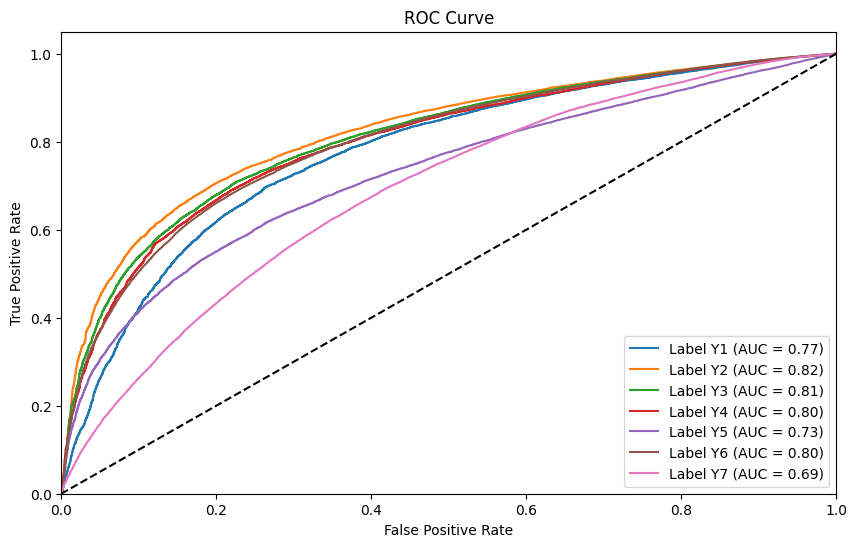

In [45]:
plt.figure(figsize=(10, 6))
roc_auc_per_label = dict()
#predictions=preds
for i in range(7):
    fpr, tpr, _ = roc_curve(y_test[:, i], prediction[:, i])
    roc_auc_per_label[i] = roc_auc_score(y_test[:, i], prediction[:, i])
    plt.plot(fpr, tpr, label='Label Y%d (AUC = %0.2f)' % (i+1, roc_auc_per_label[i]))
# Plot ROC curve for each label
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(f'Results/Prop_ROC.png')
plt.show()

In [ ]:
import pickle
model_name = f'aa_last'
with open(f'Results/{model_name}_exp.pkl', 'wb') as file:
    pickle.dump(aa_exp, file)
with open(f'Results/{model_name}_label.pkl', 'wb') as file:
    pickle.dump(aa_label, file)

### AA

In [47]:
classifier = DropoutModel(26, 7)

train_init = time.time()
classifier.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init
trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
aa_exp.append(example_based(trues, preds))
aa_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 49s 4ms/step - loss: 0.0160 - accuracy: 0.3599
Epoch 2/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0156 - accuracy: 0.3614
Epoch 3/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0156 - accuracy: 0.3525
Epoch 4/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0156 - accuracy: 0.3506
Epoch 5/5
3399/3399 [==============================] - 3s 889us/step
Train Time: 239.09516668319702 | Test Time: 4.391758918762207


In [48]:
classifier = ProposedModel1(26, 7)

train_init = time.time()
classifier.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
aa_exp.append(example_based(trues, preds))
aa_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 51s 4ms/step - loss: 0.0160 - accuracy: 0.4619
Epoch 2/5
13595/13595 [==============================] - 50s 4ms/step - loss: 0.0156 - accuracy: 0.3911
Epoch 3/5
13595/13595 [==============================] - 50s 4ms/step - loss: 0.0156 - accuracy: 0.4050
Epoch 4/5
13595/13595 [==============================] - 51s 4ms/step - loss: 0.0155 - accuracy: 0.3943
Epoch 5/5
3399/3399 [==============================] - 3s 997us/step
Train Time: 253.15575623512268 | Test Time: 4.017372369766235


In [49]:
classifier = TestModel1(26, 7)

train_init = time.time()
classifier.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
aa_exp.append(example_based(trues, preds))
aa_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 57s 4ms/step - loss: 0.0159 - accuracy: 0.3638
Epoch 2/5
13595/13595 [==============================] - 59s 4ms/step - loss: 0.0156 - accuracy: 0.3432
Epoch 3/5
13595/13595 [==============================] - 60s 4ms/step - loss: 0.0156 - accuracy: 0.3516
Epoch 4/5
13595/13595 [==============================] - 62s 5ms/step - loss: 0.0156 - accuracy: 0.3274
Epoch 5/5
3399/3399 [==============================] - 4s 1ms/step
Train Time: 299.24174308776855 | Test Time: 4.203019618988037


In [ ]:
# classifier = ProposedModel2(26, 7)

# train_init = time.time()
# classifier.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# aa_exp.append(example_based(trues, preds))
# aa_label.append(label_based(trues, preds))

In [ ]:
# classifier = WeightedDropoutModel(26, 7)

# train_init = time.time()
# classifier.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# aa_exp.append(example_based(trues, preds))
# aa_label.append(label_based(trues, preds))

In [50]:
import pickle
model_name = f'aa{DROPOUT_RATE}'
with open(f'Results/{model_name}_exp.pkl', 'wb') as file:
    pickle.dump(aa_exp, file)
with open(f'Results/{model_name}_label.pkl', 'wb') as file:
    pickle.dump(aa_label, file)

### Binary Relevance

In [36]:
KERAS_PARAMS = dict(epochs=5, batch_size=32, verbose=1)
classifier = BinaryRelevance(classifier=Keras(DropoutModel, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction.toarray())

print(f"Train Time: {train_time} | Test Time: {test_time}")
br_exp.append(example_based(trues, preds))
br_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 48s 3ms/step - loss: 0.0089 - accuracy: 0.9515
Epoch 2/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 3/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0088 - accuracy: 0.9516
Epoch 4/5
13595/13595 [==============================] - 45s 3ms/step - loss: 0.0089 - accuracy: 0.9516
Epoch 5/5
13595/13595 [==============================] - 45s 3ms/step - loss: 0.0094 - accuracy: 0.9516
Epoch 1/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0103 - accuracy: 0.9344
Epoch 2/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0100 - accuracy: 0.9347
Epoch 3/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 4/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0102 - accuracy: 0.9347
Epoch 5/5
13595/13595 [==============================] - 46s 3ms

In [37]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier = BinaryRelevance(classifier=Keras(ProposedModel1, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction.toarray())

print(f"Train Time: {train_time} | Test Time: {test_time}")
br_exp.append(example_based(trues, preds))
br_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 48s 3ms/step - loss: 0.0089 - accuracy: 0.9515
Epoch 2/5
13595/13595 [==============================] - 47s 3ms/step - loss: 0.0086 - accuracy: 0.9516
Epoch 3/5
13595/13595 [==============================] - 47s 3ms/step - loss: 0.0086 - accuracy: 0.9516
Epoch 4/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0086 - accuracy: 0.9516
Epoch 5/5
13595/13595 [==============================] - 47s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 1/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0105 - accuracy: 0.9342
Epoch 2/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0103 - accuracy: 0.9347
Epoch 3/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 4/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 5/5
13595/13595 [==============================] - 48s 4ms

In [38]:
# # KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
# classifier = BinaryRelevance(classifier=Keras(ProposedModel2, False, KERAS_PARAMS))

# train_init = time.time()
# classifier.fit(x_train, y_train)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction.toarray())

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# br_exp.append(example_based(trues, preds))
# br_label.append(label_based(trues, preds))

In [39]:
# KERAS_PARAMS = dict(epochs=5, batch_size=32, verbose=1)
# classifier = BinaryRelevance(classifier=Keras(WeightedDropoutModel, False, KERAS_PARAMS))

# train_init = time.time()
# classifier.fit(x_train, y_train)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction.toarray())

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# br_exp.append(example_based(trues, preds))
# br_label.append(label_based(trues, preds))

In [40]:
import pickle
model_name = f'br{DROPOUT_RATE}'
with open(f'Results/{model_name}_exp.pkl', 'wb') as file:
    pickle.dump(br_exp, file)
with open(f'Results/{model_name}_label.pkl', 'wb') as file:
    pickle.dump(br_label, file)

### Classifier Chain

In [41]:
import copy
import numpy as np

class ClassifierChain:
   
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y, order=None):
        """Fit classifier with training data

        Parameters
        ----------
        order: list
               The order of the labels to join training
        """
        self.m = X.shape[0]
        self.label_count = y.shape[1]
        if order is None:
            self.order = list(range(y.shape[1]))
        elif sorted(order) != list(range(y.shape[1])):
            raise ValueError('invalid order of labels')
        else:
            self.order = order
        self.classifiers = []
        X_extended = copy.deepcopy(X)
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.classifier)
            y_subset = y[:, self.order[i]]
            classifier.fit(X_extended, y_subset)
            self.classifiers.append(classifier)
            X_extended = np.hstack([X_extended, np.vstack(y_subset)])
        return self

    def predict(self, X_pre):
        res = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(self.label_count):
            y_subset = self.classifiers[i].predict(X_pre)
            X_pre = np.hstack([X_pre, np.vstack(y_subset)])
            res[:, self.order[i]] = y_subset.flatten()
        return res

In [42]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier = ClassifierChain(classifier=Keras(DropoutModel, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
cc_exp.append(example_based(trues, preds))
cc_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0094 - accuracy: 0.9509
Epoch 2/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0086 - accuracy: 0.9516
Epoch 3/5
13595/13595 [==============================] - 45s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 4/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 5/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 1/5
13595/13595 [==============================] - 47s 3ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 2/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0100 - accuracy: 0.9347
Epoch 3/5
13595/13595 [==============================] - 45s 3ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 4/5
13595/13595 [==============================] - 46s 3ms/step - loss: 0.0102 - accuracy: 0.9347
Epoch 5/5
13595/13595 [==============================] - 46s 3ms

In [43]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier = ClassifierChain(classifier=Keras(ProposedModel1, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
cc_exp.append(example_based(trues, preds))
cc_label.append(label_based(trues, preds))

Epoch 1/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0090 - accuracy: 0.9516
Epoch 2/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0086 - accuracy: 0.9516
Epoch 3/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 4/5
13595/13595 [==============================] - 47s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 5/5
13595/13595 [==============================] - 47s 3ms/step - loss: 0.0087 - accuracy: 0.9516
Epoch 1/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0102 - accuracy: 0.9347
Epoch 2/5
13595/13595 [==============================] - 48s 4ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 3/5
13595/13595 [==============================] - 49s 4ms/step - loss: 0.0101 - accuracy: 0.9347
Epoch 4/5
13595/13595 [==============================] - 49s 4ms/step - loss: 0.0100 - accuracy: 0.9347
Epoch 5/5
13595/13595 [==============================] - 48s 4ms

In [44]:
# # KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
# classifier = ClassifierChain(classifier=Keras(ProposedModel2, False, KERAS_PARAMS))

# train_init = time.time()
# classifier.fit(x_train, y_train)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# cc_exp.append(example_based(trues, preds))
# cc_label.append(label_based(trues, preds))

In [45]:
# # KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
# classifier = ClassifierChain(classifier=Keras(WeightedDropoutModel, False, KERAS_PARAMS))

# train_init = time.time()
# classifier.fit(x_train, y_train)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# cc_exp.append(example_based(trues, preds))
# cc_label.append(label_based(trues, preds))

In [46]:
import pickle
model_name = f'cc{DROPOUT_RATE}'
with open(f'Results/{model_name}_exp.pkl', 'wb') as file:
    pickle.dump(cc_exp, file)
with open(f'Results/{model_name}_label.pkl', 'wb') as file:
    pickle.dump(cc_label, file)

### Label Powerset

In [34]:
lp = LabelPowerset()
y_temp = lp.transform(y_test)
y_temp

array([ 0,  1,  0, ...,  3, 12, 34])

In [35]:
unique, counts = np.unique(y_temp, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

[[    0 36988]
 [    1 14100]
 [    2   105]
 [    3 13100]
 [    4 19812]
 [    5  2121]
 [    6   243]
 [    7    96]
 [    8   496]
 [    9  1941]
 [   10  1393]
 [   11   336]
 [   12  2300]
 [   13   181]
 [   14   338]
 [   15   110]
 [   16   588]
 [   17   475]
 [   18    80]
 [   19    79]
 [   20   141]
 [   21   875]
 [   22   529]
 [   23   285]
 [   24   623]
 [   25   190]
 [   26   440]
 [   27   508]
 [   28   342]
 [   29   957]
 [   30   618]
 [   31   465]
 [   32   552]
 [   33   179]
 [   34   832]
 [   35   643]
 [   36   124]
 [   37    10]
 [   38    99]
 [   39   621]
 [   40   151]
 [   41   146]
 [   42    92]
 [   43    61]
 [   44   565]
 [   45   268]
 [   46   154]
 [   47   107]
 [   48    47]
 [   49    34]
 [   50    88]
 [   51    14]
 [   52    75]
 [   53    96]
 [   54    45]
 [   55    74]
 [   56    10]
 [   57    83]
 [   58    16]
 [   59    31]
 [   60   145]
 [   61    12]
 [   62    57]
 [   63   187]
 [   64    88]
 [   65   130]
 [   66   

In [39]:
len(y_train)

435020

In [37]:
counts.sum()

108755

In [34]:
lp_exp = []
lp_label = []

In [35]:
def LPDropoutModel(n_inputs=26, n_outputs=7):
    model = DNNDropout(num_features=n_inputs, num_classes=n_outputs, p=0.3)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [36]:
KERAS_PARAMS = dict(epochs=1, batch_size=32, verbose=1)
classifier1 = LabelPowerset(classifier=Keras(LPDropoutModel, False, KERAS_PARAMS))

train_init = time.time()
classifier1.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier1.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction.toarray())

print(f"Train Time: {train_time} | Test Time: {test_time}")
lp_exp.append(example_based(trues, preds))
lp_label.append(label_based(trues, preds))
print(label_based(trues, preds))

3399/3399 [==============================] - 3s 952us/step
Train Time: 41.539960861206055 | Test Time: 7.273635387420654
   Subset Accuracy  Hamming Loss Accuracy (Exact Match)  \
0         0.182171       0.18329         tensor(0.8075)   

                             Precision          Recall  F1 Score  One Error  \
0  tensor(0.9084, dtype=torch.float64)  tensor(0.8814)  0.798786   0.071991   

   Coverage  Ranking Loss  Average Precision  
0  6.568958      0.315454            0.83698  


In [37]:
def LPWeightedDropoutModel(n_inputs=26, n_outputs=7):
    model = DNNWeightedDropout(num_features=n_inputs, num_classes=n_outputs, p=0.3)
    lossWeights = weight_list
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [38]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier2 = LabelPowerset(classifier=Keras(LPProposedModel1, False, KERAS_PARAMS))

train_init = time.time()
classifier2.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier2.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction.toarray())

print(f"Train Time: {train_time} | Test Time: {test_time}")
lp_exp.append(example_based(trues, preds))
lp_label.append(label_based(trues, preds))
print(label_based(trues, preds))

3399/3399 [==============================] - 3s 978us/step
Train Time: 45.3110888004303 | Test Time: 7.460609674453735
   Subset Accuracy  Hamming Loss Accuracy (Exact Match)  \
0         0.182171       0.18329         tensor(0.8075)   

                             Precision          Recall  F1 Score  One Error  \
0  tensor(0.9084, dtype=torch.float64)  tensor(0.8814)  0.798786   0.071991   

   Coverage  Ranking Loss  Average Precision  
0  6.568958      0.315454            0.83698  


In [101]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier = LabelPowerset(classifier=Keras(LPProposedModel2, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction.toarray())

print(f"Train Time: {train_time} | Test Time: {test_time}")
lp_exp.append(example_based(trues, preds))
lp_label.append(label_based(trues, preds))
print(label_based(trues, preds))

3399/3399 [==============================] - 3s 1ms/step
Train Time: 45.76464009284973 | Test Time: 7.314046382904053


KeyboardInterrupt: 

In [ ]:
# KERAS_PARAMS = dict(epochs=5, batch_size=32, verbose=0)
classifier = LabelPowerset(classifier=Keras(LPWeightedDropoutModel, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction.toarray())

print(f"Train Time: {train_time} | Test Time: {test_time}")
lp_exp.append(example_based(trues, preds))
lp_label.append(label_based(trues, preds))
print(label_based(trues, preds))

3399/3399 [==============================] - 3s 880us/step
Train Time: 205.77587723731995 | Test Time: 7.054391145706177
   Subset Accuracy  Hamming Loss Accuracy (Exact Match)  \
0         0.004257      0.444514         tensor(0.5231)   

                             Precision          Recall  F1 Score  One Error  \
0  tensor(0.5804, dtype=torch.float64)  tensor(0.8431)  0.517714   0.071952   

   Coverage  Ranking Loss  Average Precision  
0  6.933373      0.440487           0.836675  


In [ ]:
import pickle
model_name = 'lp2'
with open(f'Results/{model_name}_exp.pkl', 'wb') as file:
    pickle.dump(lp_exp, file)
with open(f'Results/{model_name}_label.pkl', 'wb') as file:
    pickle.dump(lp_label, file)

### CLR

In [47]:
class CalibratedLabelRanking:
    """Calibratedn Label Ranking
    Reference Paper:
        Min-Ling Zhang and Zhi-Hua Zhou. A Review on Multi-Label Learning Algorithms
        Johannes Fürnkranz. Multilabel classification via calibrated label ranking
    """
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        self.virtualLabel = y.shape[1]
        self.label_count = y.shape[1]
        self.m = X.shape[0]
        self.X = X
        self.y = y
        self.realLabelClassifiers = []
        self.virtualLabelClassifiers = []
        self.trainRealLabelClassifiers()
        self.trainVirtualLabelClassifiers()
        return self

    def trainRealLabelClassifiers(self):
        for i in range(self.label_count):
            for j in range(i+1, self.label_count):
                X_subset = []
                y_subset = []
                classifier = copy.deepcopy(self.classifier)
                for k in range(self.m):
                    if self.y[k, i] == self.y[k, j]:
                        continue
                    elif self.y[k, i] == 1:
                        X_subset.append(self.X[k, :])
                        y_subset.append(i)
                    else:
                        X_subset.append(self.X[k, :])
                        y_subset.append(j)
                try:
                    classifier.fit(np.vstack(X_subset), np.array(y_subset))
                except ValueError:
                    if y_subset[0] == i:
                        classifier = i
                    else:
                        classifier = j
                self.realLabelClassifiers.append(classifier)

    def trainVirtualLabelClassifiers(self):
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.classifier)
            y_temp= self.y[:, i]
            y_subset = []
            for j in range(self.m):
                y_subset.append(i if y_temp[j] == 1 else self.virtualLabel)
            classifier.fit(self.X, y_subset)
            self.virtualLabelClassifiers.append(classifier)

    def predict(self, X_pre):
        result = np.zeros((X_pre.shape[0], self.label_count))
        threshold = self.voteForVirtualLabel(X_pre)
        votes = self.voteForRealLabel(X_pre)
        for i in range(X_pre.shape[0]):
            result[i, votes[i,:] > threshold[i]] = 1
        return result

    def voteForVirtualLabel(self, X_pre):
        votes = np.zeros(X_pre.shape[0])
        for i in range(len(self.virtualLabelClassifiers)):
            predict = self.virtualLabelClassifiers[i].predict(X_pre)
            for j in range(X_pre.shape[0]):
                if predict[j] == self.virtualLabel:
                    votes[j] += 1
        return votes

    def voteForRealLabel(self, X_pre):
        votes = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(len(self.realLabelClassifiers)):
            if isinstance(self.realLabelClassifiers[i], int):
                predict = np.array([self.realLabelClassifiers[i]] * X_pre.shape[0])
            else:
                predict = self.realLabelClassifiers[i].predict(X_pre)
            for j in range(X_pre.shape[0]):
                votes[j, predict[j]] += 1
        for j in range(len(self.virtualLabelClassifiers)):
            predict = self.virtualLabelClassifiers[j].predict(X_pre)
            for j in range(X_pre.shape[0]):
                if predict[j] < self.virtualLabel:
                    votes[j, predict[j]] += 1
        return votes
            

In [48]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier = CalibratedLabelRanking(classifier=Keras(DropoutModel, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
clr_exp.append(example_based(trues, preds))
clr_label.append(label_based(trues, preds))

Epoch 1/5
1252/1252 [==============================] - 5s 4ms/step - loss: 0.0321 - accuracy: 0.5965
Epoch 2/5
1252/1252 [==============================] - 4s 3ms/step - loss: 0.0315 - accuracy: 0.6149
Epoch 3/5
1252/1252 [==============================] - 4s 3ms/step - loss: 0.0314 - accuracy: 0.6188
Epoch 4/5
1252/1252 [==============================] - 4s 3ms/step - loss: 0.0314 - accuracy: 0.6231
Epoch 5/5
1252/1252 [==============================] - 4s 3ms/step - loss: 0.0313 - accuracy: 0.6215
Epoch 1/5
1233/1233 [==============================] - 5s 3ms/step - loss: 0.0318 - accuracy: 0.6025
Epoch 2/5
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0315 - accuracy: 0.6154
Epoch 3/5
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0314 - accuracy: 0.6178
Epoch 4/5
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0313 - accuracy: 0.6202
Epoch 5/5
1233/1233 [==============================] - 4s 3ms/step - loss: 0.0314 - accurac

In [49]:
# KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
classifier = CalibratedLabelRanking(classifier=Keras(ProposedModel1, False, KERAS_PARAMS))

train_init = time.time()
classifier.fit(x_train, y_train)
train_time = time.time() - train_init

test_init = time.time()
prediction = classifier.predict(x_test)
test_time = time.time() - test_init

trues = torch.tensor(y_test)
preds = torch.tensor(prediction)

print(f"Train Time: {train_time} | Test Time: {test_time}")
clr_exp.append(example_based(trues, preds))
clr_label.append(label_based(trues, preds))

Epoch 1/5
1252/1252 [==============================] - 6s 4ms/step - loss: 0.0317 - accuracy: 0.6163
Epoch 2/5
1252/1252 [==============================] - 5s 4ms/step - loss: 0.0314 - accuracy: 0.6241
Epoch 3/5
1252/1252 [==============================] - 5s 4ms/step - loss: 0.0314 - accuracy: 0.6230
Epoch 4/5
1252/1252 [==============================] - 5s 4ms/step - loss: 0.0313 - accuracy: 0.6239
Epoch 5/5
1252/1252 [==============================] - 5s 4ms/step - loss: 0.0313 - accuracy: 0.6243
Epoch 1/5
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0318 - accuracy: 0.6046
Epoch 2/5
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0314 - accuracy: 0.6183
Epoch 3/5
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0314 - accuracy: 0.6182
Epoch 4/5
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0313 - accuracy: 0.6213
Epoch 5/5
1233/1233 [==============================] - 5s 4ms/step - loss: 0.0313 - accurac

In [50]:
# # KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
# classifier = CalibratedLabelRanking(classifier=Keras(ProposedModel2, False, KERAS_PARAMS))

# train_init = time.time()
# classifier.fit(x_train, y_train)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# clr_exp.append(example_based(trues, preds))
# clr_label.append(label_based(trues, preds))

In [51]:
# # KERAS_PARAMS = dict(epochs=10, batch_size=32, verbose=0)
# classifier = CalibratedLabelRanking(classifier=Keras(WeightedDropoutModel, False, KERAS_PARAMS))

# train_init = time.time()
# classifier.fit(x_train, y_train)
# train_time = time.time() - train_init

# test_init = time.time()
# prediction = classifier.predict(x_test)
# test_time = time.time() - test_init

# trues = torch.tensor(y_test)
# preds = torch.tensor(prediction)

# print(f"Train Time: {train_time} | Test Time: {test_time}")
# clr_exp.append(example_based(trues, preds))
# clr_label.append(label_based(trues, preds))

In [52]:
import pickle
model_name = f'clr{DROPOUT_RATE}'
with open(f'Results/{model_name}_exp.pkl', 'wb') as file:
    pickle.dump(clr_exp, file)
with open(f'Results/{model_name}_label.pkl', 'wb') as file:
    pickle.dump(clr_label, file)